# **Практика 4**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.signal import argrelextrema
import warnings

warnings.filterwarnings("ignore")

In [21]:
# Загрузка данных
df = pd.read_csv('daily_storm_data_novorossiysk.csv', parse_dates=['time'])
df = df.set_index('time').sort_index()

# Используем температуру как основной показатель для анализа
y = df['temperature_2m_avg'].values
dates = df.index
raw_y = y.copy()

# Сглаживание для удаления шума
y = pd.Series(y).rolling(window=7, center=True).mean().fillna(method='bfill').fillna(method='ffill').values

In [22]:
# 1. Разделение на быстрые и медленные движенияЕМЕННОГО РЯДА

window_size = 30
slow_movement = pd.Series(y).rolling(window=window_size, center=True, min_periods=1).mean()
fast_movement = y - slow_movement

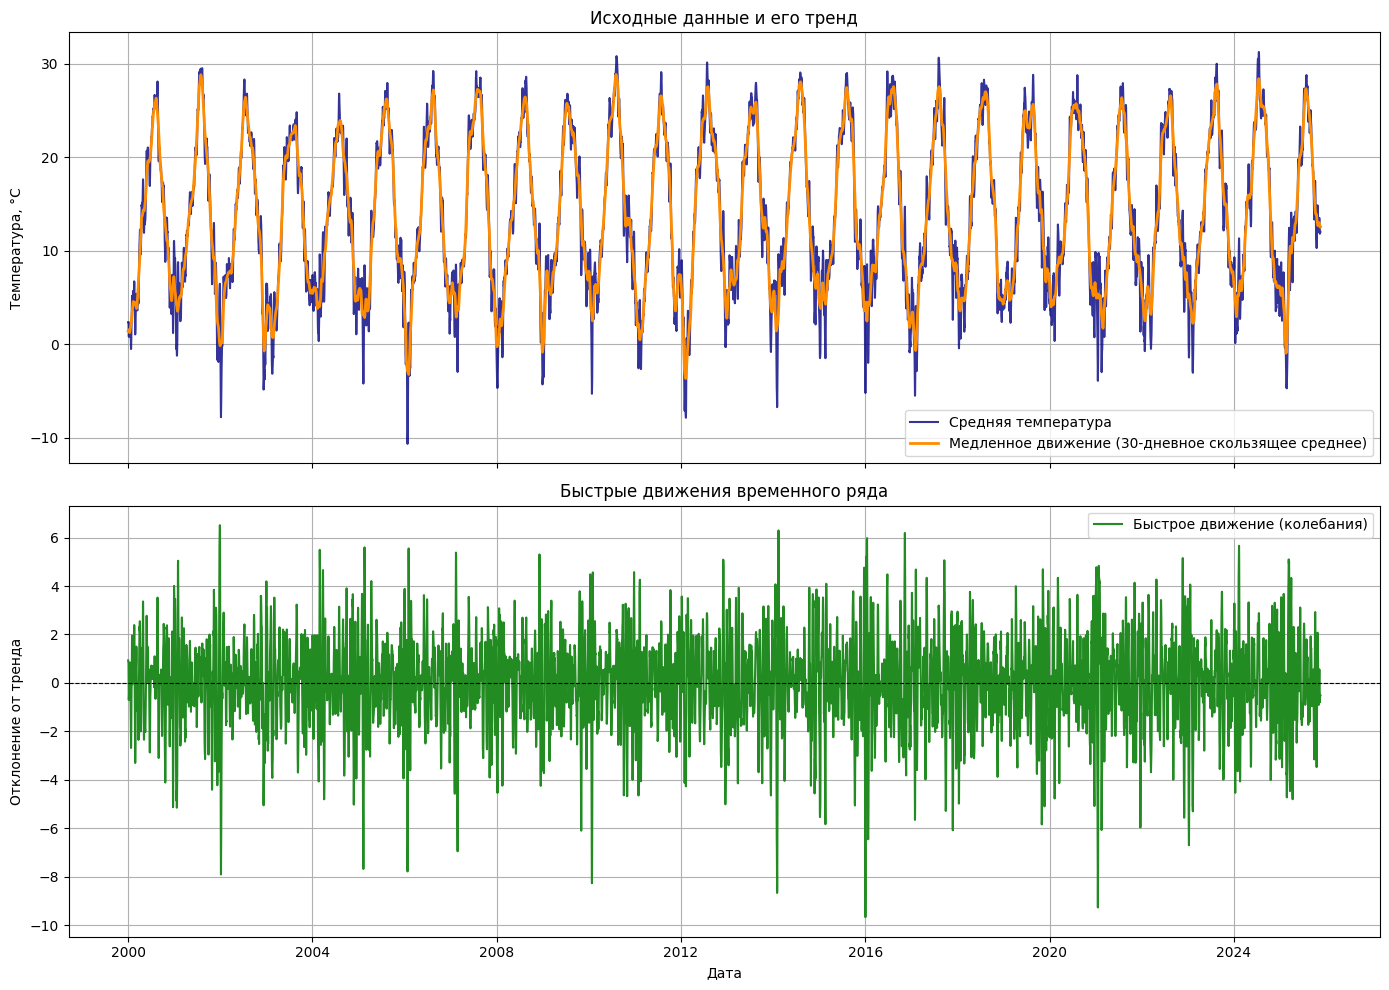

In [23]:
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(dates, y, label='Средняя температура', color='navy', alpha=0.8)
ax1.plot(dates, slow_movement, label=f'Медленное движение ({window_size}-дневное скользящее среднее)',
         color='darkorange', linewidth=2)
ax1.set_ylabel('Температура, °C')
ax1.set_title('Исходные данные и его тренд')
ax1.legend()
ax1.grid(True)

ax2.plot(dates, fast_movement, label='Быстрое движение (колебания)', color='forestgreen')
ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax2.set_xlabel('Дата')
ax2.set_ylabel('Отклонение от тренда')
ax2.set_title('Быстрые движения временного ряда')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [24]:
# 2. Сдвиговая функция

def calculate_shift_function(y_data, delta_t, max_tau):
    n = len(y_data)

    z_metric = np.full(n, np.nan)
    for t in range(delta_t, n - delta_t):
        try:
            val = (y_data[t - delta_t] * y_data[t + delta_t]) / (y_data[t] ** 2)
            if val > 0:
                z_metric[t] = np.log(val)
        except:
            pass

    a_tau = []
    valid_taus = []

    for tau in range(1, max_tau + 1):
        diffs = []
        for t in range(delta_t, n - delta_t - tau):
            v1 = z_metric[t]
            v2 = z_metric[t + tau]
            if not np.isnan(v1) and not np.isnan(v2):
                diffs.append(abs(v2 - v1))

        if len(diffs) > 10:
            a_tau.append(np.mean(diffs))
            valid_taus.append(tau)

    return np.array(valid_taus), np.array(a_tau)

Значимые почти-периоды: [  4  10  16  20  26  31  36  40  44 319 323 328 332 337 340 345 350 354
 359 362 366 369 371 379 382 390 399 405 413 683 687 693 697 705 708 714
 719 724 728] дней


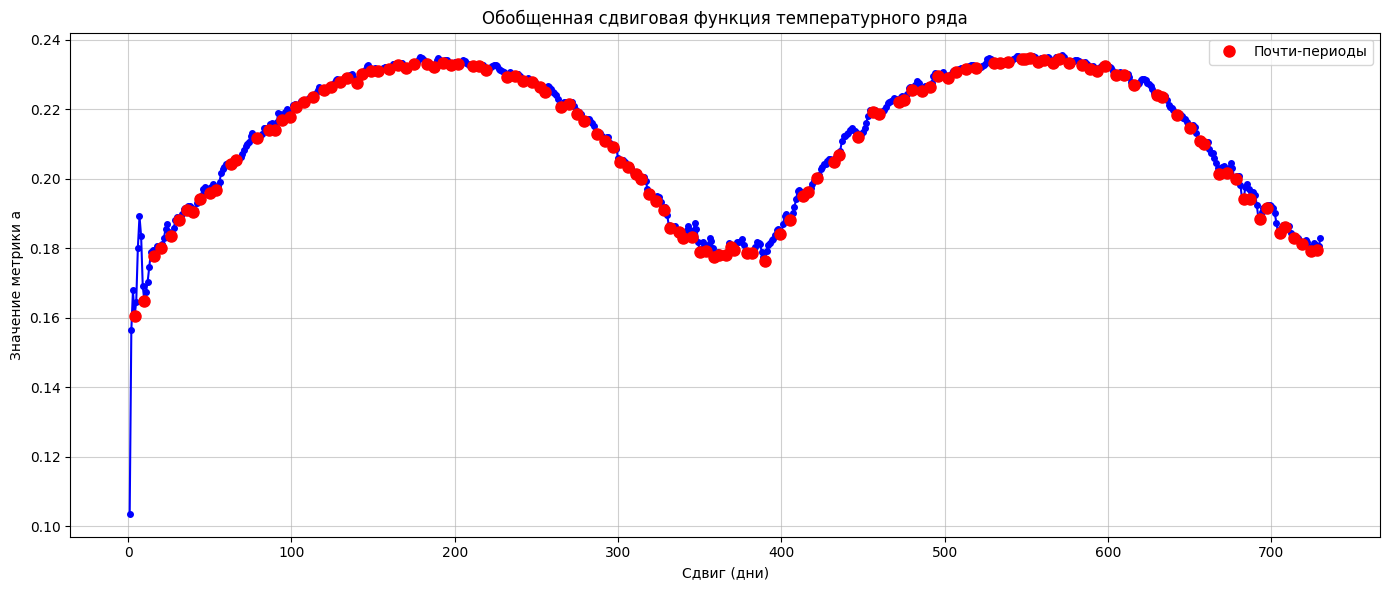

In [16]:
DELTA_T = 2
MAX_TAU = 365*2

taus, a_vals = calculate_shift_function(y, DELTA_T, MAX_TAU)

fig2, ax = plt.subplots(figsize=(14, 6))
ax.plot(taus, a_vals, 'b-o', markersize=4, linewidth=1.5)

# Находим локальные минимумы - почти периоды
min_idx = argrelextrema(a_vals, np.less)[0]
ax.plot(taus[min_idx], a_vals[min_idx], 'ro', markersize=8, label='Почти-периоды')

ax.set_title(f'Обобщенная сдвиговая функция температурного ряда')
ax.set_xlabel('Сдвиг (дни)')
ax.set_ylabel('Значение метрики a')
ax.grid(True, alpha=0.6)
ax.legend()

# Выводим найденные периоды
significant_periods = taus[min_idx][a_vals[min_idx] < np.percentile(a_vals, 25)]
print(f"Значимые почти-периоды: {significant_periods} дней")

plt.tight_layout()
plt.show()

In [17]:
# 3. Оценка трендовых характеристик

def evaluate_trends(segment):
    n = len(segment)
    if n < 5:
        return np.zeros(5)

    t = np.arange(1, n + 1).reshape(-1, 1)
    y_val = segment

    # Вычисляем производную (скорость изменения)
    dy = np.zeros(n)
    dy[1:-1] = (y_val[2:] - y_val[:-2]) / 2
    dy[0] = dy[1]
    dy[-1] = dy[-2]

    # Относительная скорость роста
    with np.errstate(divide='ignore', invalid='ignore'):
        growth_rate = dy / y_val

    scores = np.zeros(5)  # 5 типов роста

    # 1. Интенсивный рост (1/y ~ t)
    try:
        Y = 1 / y_val
        model = LinearRegression().fit(t, Y)
        scores[0] = r2_score(Y, model.predict(t))
    except:
        pass

    # 2. Гомперц (ln(dy/y) ~ t)
    try:
        mask = (growth_rate > 0) & (y_val > 0)
        if np.sum(mask) > n // 3:
            X = t[mask]
            Y = np.log(growth_rate[mask])
            model = LinearRegression().fit(X, Y)
            if model.coef_[0] < 0:  # Замедление роста
                scores[1] = r2_score(Y, model.predict(X))
    except:
        pass

    # 3. Экспоненциальный (ln(y) ~ t)
    try:
        Y = np.log(y_val)
        model = LinearRegression().fit(t, Y)
        if model.coef_[0] > 0:  # Рост
            scores[2] = r2_score(Y, model.predict(t))
    except:
        pass

    # 4. Степенной (ln(y) ~ ln(t))
    try:
        X = np.log(t)
        Y = np.log(y_val)
        model = LinearRegression().fit(X, Y)
        scores[3] = r2_score(Y, model.predict(X))
    except:
        pass

    # 5. Логистический (dy/y ~ y)
    try:
        X = y_val.reshape(-1, 1)
        Y = growth_rate
        model = LinearRegression().fit(X, Y)
        if model.coef_[0] < 0:  # Замедление с ростом
            scores[4] = r2_score(Y, model.predict(X))
    except:
        pass

    return scores

In [18]:
# Параметры анализа
WINDOW_SIZE = 90
STEP = 30
R2_THRESHOLD = 0.6

COLORS = {
    1: 'red',    # Интенсивный
    2: 'green',  # Гомперц
    3: 'blue',   # Экспоненциальный
    4: 'purple', # Степенной
    5: 'orange'  # Логистический
}

MODEL_NAMES = {
    1: 'Интенсивный',
    2: 'Гомперц',
    3: 'Экспоненциальный',
    4: 'Степенной',
    5: 'Логистический'
}

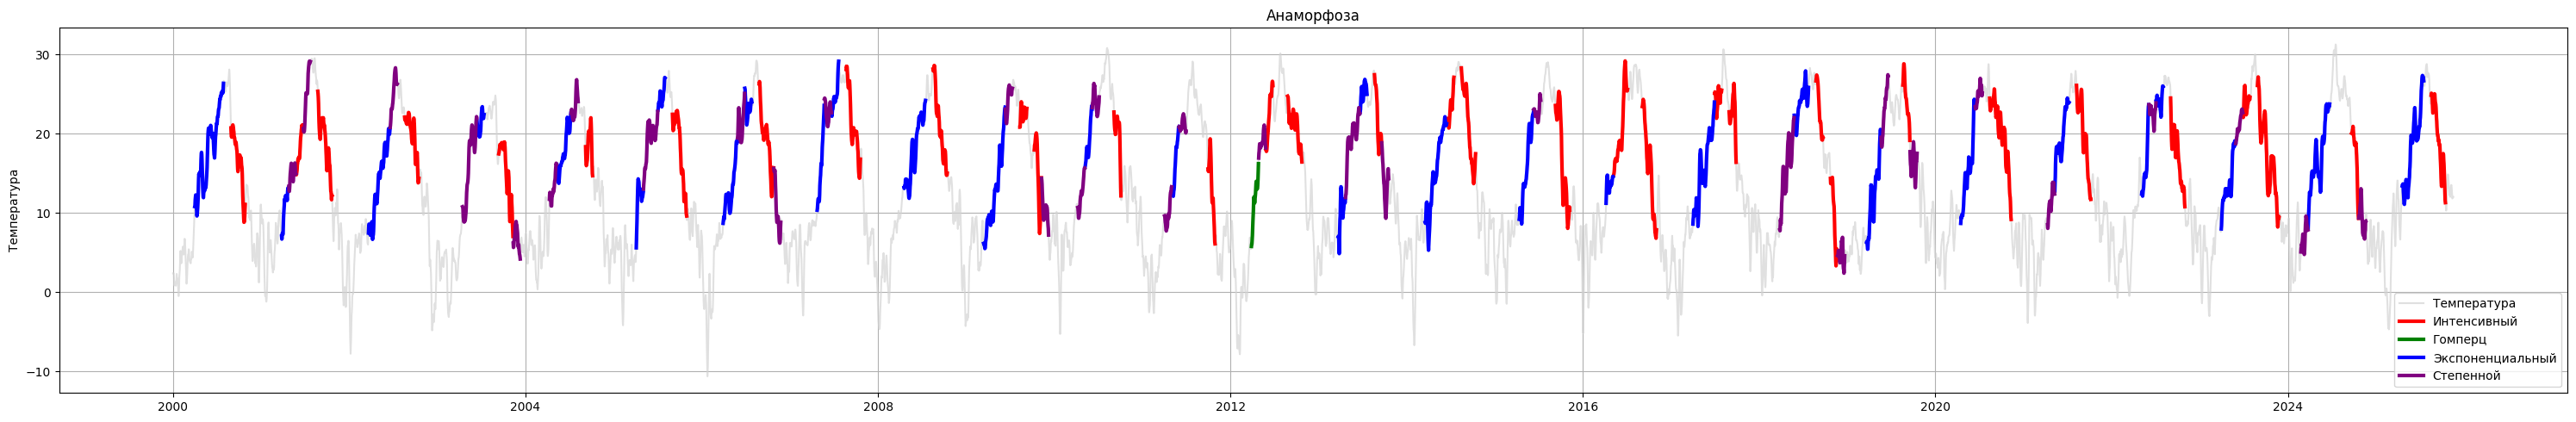

In [19]:
# Анализ трендов по скользящим окнам
trend_map = np.zeros(len(y), dtype=int)
trend_scores = np.zeros(len(y))

for i in range(0, len(y) - WINDOW_SIZE, STEP):
    segment = y[i:i + WINDOW_SIZE]
    scores = evaluate_trends(segment)

    best_score = np.max(scores)
    best_model_idx = np.argmax(scores) + 1

    if best_score > R2_THRESHOLD:
        # Заполняем область вокруг центра окна
        center = i + WINDOW_SIZE // 2
        start_fill = max(0, center - STEP // 2)
        end_fill = min(len(y), center + STEP // 2)

        for idx in range(start_fill, end_fill):
            if best_score > trend_scores[idx]:
                trend_scores[idx] = best_score
                trend_map[idx] = best_model_idx

# Визуализация результатов
fig4, ax1 = plt.subplots(figsize=(30, 5))

# Исходные данные с классификацией
ax1.plot(dates, y, color='lightgray', alpha=0.7, label='Температура')
added_labels = set()

for model_id, color in COLORS.items():
    mask = trend_map == model_id

    # Находим непрерывные сегменты
    padded_mask = np.concatenate(([False], mask, [False]))
    diff = np.diff(padded_mask.astype(int))

    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]

    for start, end in zip(starts, ends):
        if end - start > 7:  # Минимальная длина сегмента
            label = MODEL_NAMES[model_id] if MODEL_NAMES[model_id] not in added_labels else ""
            ax1.plot(dates[start:end], y[start:end], color=color,
                    linewidth=3, label=label)
            added_labels.add(MODEL_NAMES[model_id])

ax1.set_title('Анаморфоза')
ax1.set_ylabel('Температура')
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.show()